# CFF Fitting using Gepard

## Dataset

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import os
import sys
import gepard as g # NeuralModel with Dispersion relation added 
from gepard import model, fitter, data, plots
import gepard.plots as gplot
from gepard.fits import GLO15new, AUTIpts, ALUIpts
print('Gepard version = {}'.format(g.__version__))

Gepard version = 0.9.11b0


In [5]:
import torch
import numpy as np 
#np.set_printoptions(legacy='1.25')
import matplotlib
import matplotlib.pyplot as plt
import shelve, logging, copy
logging.basicConfig(level=logging.ERROR) 
import pandas as pd 
from scipy.integrate import quad
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.stats import norm


In [6]:
import gmaster as gm
from gmaster.fits import GLO15new, AUTIpts, ALUIpts, th_KM15, th_KM10b # need KM15 for simulated data
th15 = th_KM15
from gmaster.constants import Mp2, toTeX

### To add our data files to gepard


In [7]:
sys.path.append('/Users/higuera-admin/Documents/Programs/ldrdgff/gepard/src/gepard/')
#sys.path.append('/Users/higuera-admin/Documents/Programs/ldrdgff/gepardDevel/gdevel/src/gdevel')
import mydatafiles
from mydatafiles import ep2epgamma

mydset = g.data.loaddata(mydatafiles)
mydset.update(g.data.loaddata(ep2epgamma))

In [6]:
#GEPARD_DIR = os.path.dirname(g.__file__)
#db = shelve.open(GEPARD_DIR+'/theories.db') 

'''with shelve.open(GEPARD_DIR+'/theories.db', flag='r') as db:
    # Example: Retrieve a value by key
    #value = db.get('your_key', 'default_value')
    #print(value)

    # Example: List all keys
    keys = list(db.keys())
    print(keys)

    # Example: Modify or add a value
    #db['new_key'] = 'new_value'

    # Example: Delete a key
    #if 'old_key' in db:
        #del db['old_key'] '''

"with shelve.open(GEPARD_DIR+'/theories.db', flag='r') as db:\n    # Example: Retrieve a value by key\n    #value = db.get('your_key', 'default_value')\n    #print(value)\n\n    # Example: List all keys\n    keys = list(db.keys())\n    print(keys)\n\n    # Example: Modify or add a value\n    #db['new_key'] = 'new_value'\n\n    # Example: Delete a key\n    #if 'old_key' in db:\n        #del db['old_key'] "

In [8]:
# To have nice LaTeX fonts on plots
plt.rc('text', usetex=True)
params = {'text.latex.preamble' : '\n'.join([r'\usepackage{amssymb}', r'\usepackage{amsmath}'])}
plt.rcParams.update(params)

In [9]:
#utils.listdata([101,102], data)
fitpoints = g.dset[101] + g.dset[102] + g.dset[8] #+ mydset[183] + mydset[193] #+ g.dset[97] + g.dset[7] + g.dset[99] #+
g.describe_data(fitpoints)

#fitpoints = mydset[325] 
#g.describe_data(fitpoints)

npt x obs     collab  FTn    id  ref.        
----------------------------------------------
12 x ALU     CLAS    -1.0   8   arXiv:0711.4805
48 x XLUw    CLAS    -1     101 arXiv:1504.02009
48 x XUUw    CLAS    0.0    102 arXiv:1504.02009
48 x XUUw    CLAS    1.0    102 arXiv:1504.02009
----------------------------------------------
TOTAL = 156


In [10]:
#utils.listdata([8], data)
#data = mydset[193]
#BSA = data.df()   # ALU(90 deg) by CLAS 2007
data = g.dset[8]
BSA = data.df() 
data = g.dset[102]
BSS = data.df()  # CLAS 2015
data = g.dset[101]
BSD = data.df()  # CLAS 2015

#data = g.dset[90]
#BTSA = data.df()  # CLAS 2015

#data = mydset[325]
#BTSA = data.df()  # CLAS 2022

In [11]:
# Bins can be defined as ranges within the following limiting values:
tmlims = [0, 0.13, 0.18, 0.22, 0.3, 0.4, 0.5]
xilims = [0, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21, 0.23, 0.26]

Text(0, 0.5, '$-t\\quad[{\\rm GeV}^2]$')

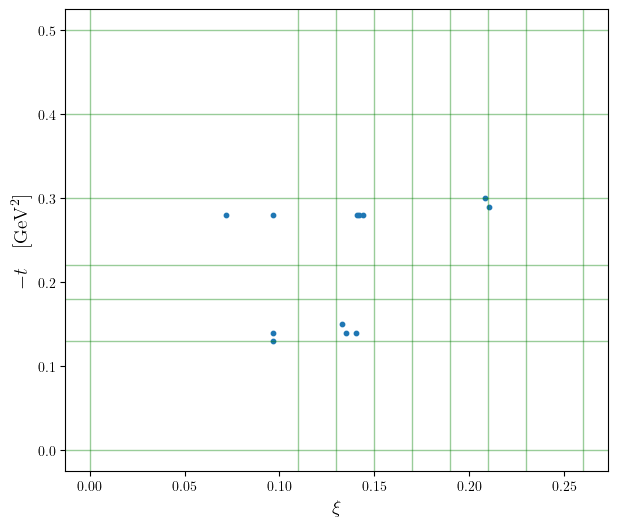

In [12]:
fig, ax = plt.subplots(figsize=[7,6])
ax.scatter(BSA.xi, BSA.tm, s=10)
for tm in tmlims:
    ax.axhline(tm, color='g', linewidth=1, alpha=0.4)
for xi in xilims:
    ax.axvline(xi, color='g', linewidth=1, alpha=0.4)
ax.set_xlabel(r'$\xi$', fontsize=14)
ax.set_ylabel(r'$-t\quad[{\rm GeV}^2]$', fontsize=14)

Text(0, 0.5, '$-t\\quad[{\\rm GeV}^2]$')

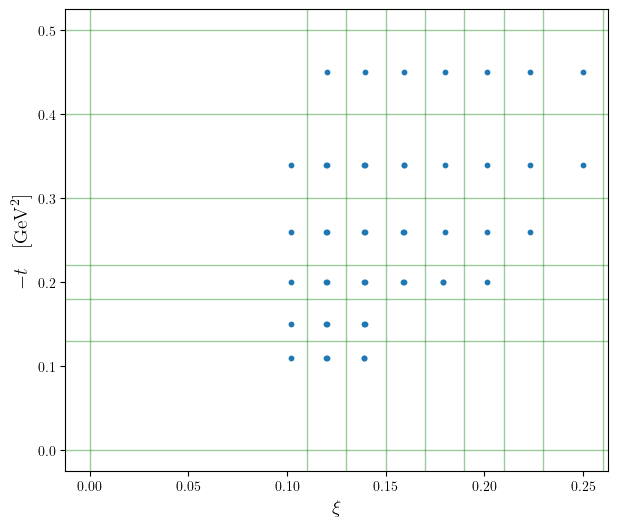

In [13]:
#plt.rcParams.update(plt.rcParamsDefault)
fig, ax = plt.subplots(figsize=[7,6])
ax.scatter(BSD.xi, BSD.tm, s=10)
for tm in tmlims:
    ax.axhline(tm, color='g', linewidth=1, alpha=0.4)
for xi in xilims:
    ax.axvline(xi, color='g', linewidth=1, alpha=0.4)
ax.set_xlabel(r'$\xi$', fontsize=14)
ax.set_ylabel(r'$-t\quad[{\rm GeV}^2]$', fontsize=14)
#fig.savefig('bins.pdf')

Text(0, 0.5, '$-t\\quad[{\\rm GeV}^2]$')

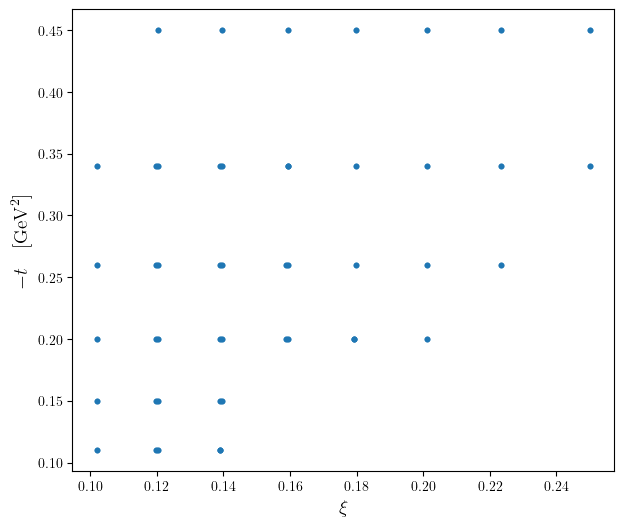

In [14]:
fig, ax = plt.subplots(figsize=[7,6])
plt.scatter(BSS.xi, BSS.tm, s=10)
ax.set_xlabel(r'$\xi$', fontsize=14)
ax.set_ylabel(r'$-t\quad[{\rm GeV}^2]$', fontsize=14)

## Fit with NN

In [15]:
class NNTest(g.model.NeuralModel, g.eff.DipoleEFF, g.dvcs.BMK):
    
    def build_net(self):
        '''Overriding the default architecture and optimizer'''
        nn_model = torch.nn.Sequential(
                torch.nn.Linear(2, 23),
                torch.nn.ReLU(),
                torch.nn.Linear(23, 37),
                torch.nn.ReLU(),
                torch.nn.Linear(37, 19),
                torch.nn.ReLU(),
                torch.nn.Linear(19, len(self.output_layer))
            )
        optimizer = torch.optim.Rprop(nn_model.parameters(),
                lr=0.05)
        return nn_model, optimizer

In [16]:
g.describe_data(fitpoints)
th = NNTest(output_layer=['ImH', 'ReH'])#'ImH', 'ReH', 'ImE', 'ReE', 'ImHt', 'ReHt', 'ImEt', 'ReEt'])#
print(th.useDR)

npt x obs     collab  FTn    id  ref.        
----------------------------------------------
12 x ALU     CLAS    -1.0   8   arXiv:0711.4805
48 x XLUw    CLAS    -1     101 arXiv:1504.02009
48 x XUUw    CLAS    0.0    102 arXiv:1504.02009
48 x XUUw    CLAS    1.0    102 arXiv:1504.02009
----------------------------------------------
TOTAL = 156
None


In [20]:
#f = g.fitter.NeuralFitter(fitpoints, th, nnets=10, maxtries=100, nbatch=6, batchlen=10, minprob=0.05)
#f.fit()
f = g.fitter.NeuralFitter(fitpoints, th, nnets=5, nbatch=50, batchlen=3, regularization='L2', lx_lambda=0.01)
f.fit()


Epoch   3: train error = 4.1450 test error = 9.6670 -
Epoch   6: train error = 2.4515 test error = 4.0781 -
Epoch   9: train error = 2.0377 test error = 2.6581 -
Epoch  12: train error = 1.5495 test error = 1.5882 -
Epoch  15: train error = 1.3603 test error = 1.8341 +
Epoch  18: train error = 1.2409 test error = 1.8282 +
Epoch  21: train error = 1.1986 test error = 1.9838 +
Epoch  24: train error = 1.1582 test error = 2.0348 +
Epoch  27: train error = 1.1342 test error = 2.2422 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.5881619307684043

Epoch   3: train error = 1.9311 test error = 15.3669 -
Epoch   6: train error = 2.0066 test error = 4.9188 -
Epoch   9: train error = 1.3890 test error = 2.4381 -
Epoch  12: train error = 1.2577 test error = 1.6953 -
Epoch  15: train error = 1.1013 test error = 1.6205 -
Epoch  18: train error = 1.0096 test error = 1.6046 -
Epoch  21: train error = 0.9838 test error = 1.5490 -
Epoch  24: train error = 0.9621 test error = 1.

### Use shelve to store the trained models

In [21]:
with shelve.open("CLAS15-8-NDR") as shelve_file:
    # Store num list in shelf file 
    
    shelve_file['NoDR'] = th.nets
    NoDR=shelve_file['NoDR']  

    th4 = NNTest(output_layer=['ImH', 'ReH'])
    th4.nets = NoDR  
    print(f"Keys = {list(shelve_file.keys())}")

Keys = ['NoDR', 'DR']


### Various tests

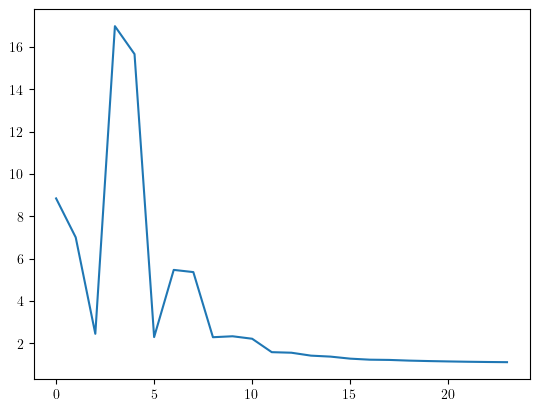

Fit on CLAS data


In [22]:
plt.figure()
plt.plot(f.history)
plt.show()
th.name = "Fit on CLAS data"
print(th.name)

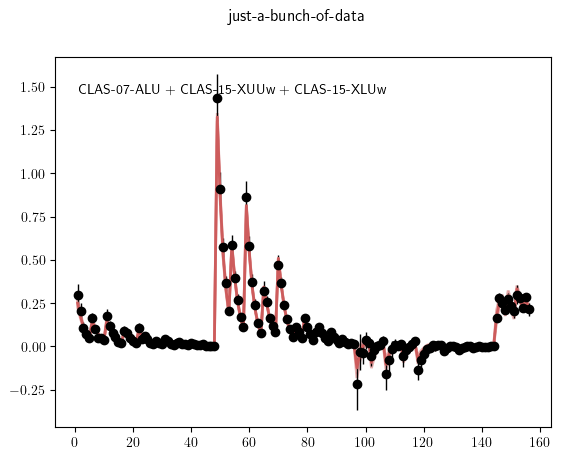

In [23]:
fig = gplot.jbod(points=fitpoints, lines=[th], bands=[th])

In [24]:
#%%time
th.chisq(g.dset[101] + g.dset[102] + g.dset[8])

(np.float64(44.44496837540494), 156, np.float64(1.0))

### CFFs plots in the no DR case

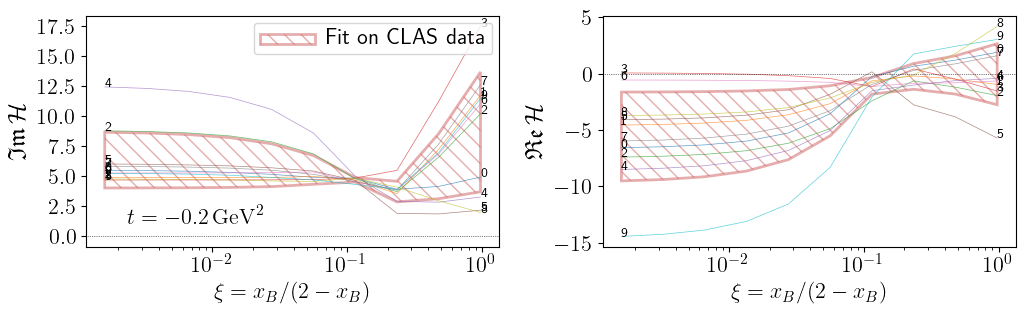

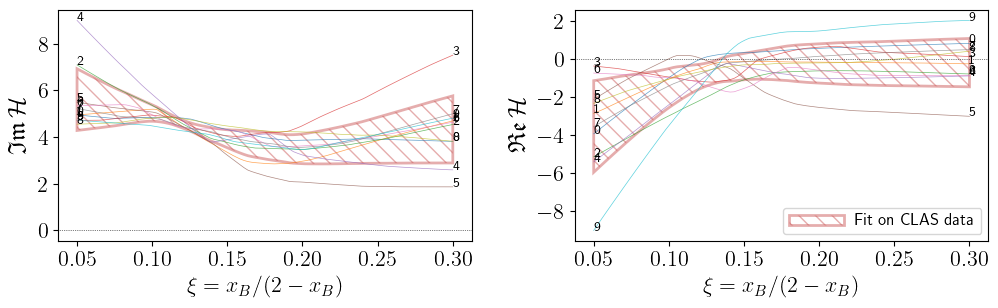

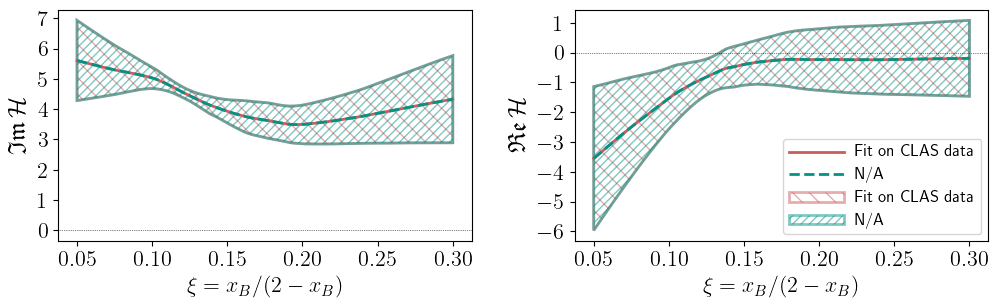

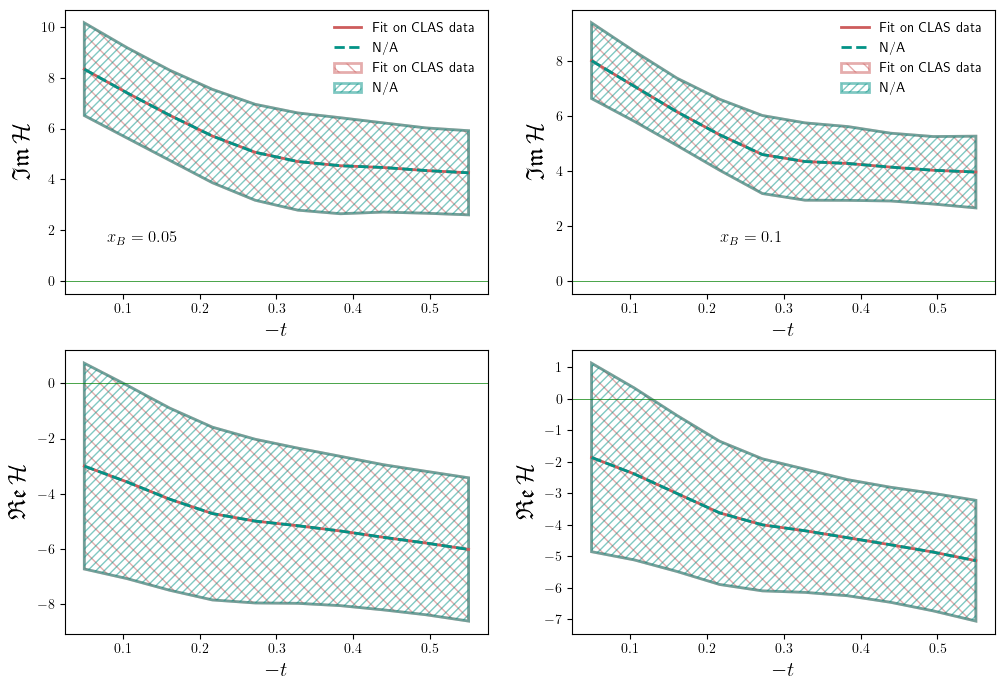

In [25]:
#fig = gplot.CFF3(cffs=['ImH', 'ReH'],  bands=[th], tval=-0.2)
fig = gplot.CFF3log(cffs=['ImH', 'ReH'],  mesh=th, bands=[th], tval=-0.2)
fig = gplot.CFF3(cffs=['ImH', 'ReH'],  mesh=th, bands=[th])
fig = gplot.CFF3(cffs=['ImH', 'ReH'],  lines=[th, th4], bands=[th, th4])
fig = gplot.CFFt(cffs=['ImH', 'ReH'],  lines=[th, th4], bands=[th, th4])
#fig.savefig('NN-mesh.pdf', bbox_inches='tight', transparent=True, pad_inches=0)

## Custom NN

In [26]:
import torch.nn as nn
class CustomNetwork(nn.Module):
    def __init__(self):
        super(CustomNetwork, self).__init__()

        # Define the layers for the network
        self.n1 = nn.Linear(2, 20)  # 2 input features, 12 hidden units
        self.n2 = nn.Linear(20, 25)  # 12 hidden units, 17 hidden units
        self.n3 = nn.Linear(25, 1)  # 7 hidden units, 1 output features
        
        self.n1p = nn.Linear(1, 20)  # 2 input features, 12 hidden units
        self.n2p = nn.Linear(20, 25)  # 12 hidden units, 17 hidden units
        self.n3p = nn.Linear(25, 1)  # 17 hidden units, 1 output features

    def forward(self, x):
        
       
        x0 = x
        
        # Build Im network
        x = torch.relu(self.n1(x0))
        x = torch.relu(self.n2(x))
        output1 = self.n3(x)
        
        # Build D network
        # build the input tensor
        x0_1 = torch.cat((x0[:,1].unsqueeze(1),), dim=0)
       
        x2 = torch.relu(self.n1p(x0_1))
        x2 = torch.relu(self.n2p(x2))
        output2 = self.n3p(x2)
        
        #concatenate outputs
        output = torch.cat((output1, output2), dim=1)
       
        return output 

### Create the class inheriting from DispersionCFF

In [27]:
class NNTest_DR(g.model.NeuralModel_DR, g.eff.DipoleEFF, g.dvcs.BMK, g.cff.DispersionCFF):
    
    def build_net(self):
        '''Overriding the default architecture and optimizer'''
        nn_model = CustomNetwork()
        optimizer = torch.optim.Rprop(nn_model.parameters(),
                lr=0.01)
        return nn_model, optimizer
    
    def subtraction(self, pt): #This should use the NN, the real part will be calculated by the CFF_Dispersion methods
        """Subtraction constant."""
        #refer to the location of D in output layer (defined in the next cell)
        return self.cffs(1, pt, xi)
    
    def ImH(self, pt, xi=0) -> float:
        """Return Im(CFF H) for kinematic point."""
        #refer to the location of Im H in output layer (defined in the next cell)
        return self.cffs(0, pt, xi)
    
    def ImE(self, pt, xi=0):
        """Return Im(CFF E) for kinematic point."""
        return self.zero(pt)
    
    def ImHt(self, pt, xi=0):
        """Return Im(CFF Ht) for kinematic point."""
        return self.zero(pt)
    
    def ImEt(self, pt, xi=0):
        """Return Im(CFF Et) for kinematic point."""
        return self.zero(pt)

In [28]:
th2 = NNTest_DR(output_layer=['ImH', 'D'])#'ImH', 'ReH', 'ImE', 'ReE', 'ImHt', 'ReHt', 'ImEt', 'ReEt'])#

In [29]:
g.describe_data(fitpoints)

npt x obs     collab  FTn    id  ref.        
----------------------------------------------
12 x ALU     CLAS    -1.0   8   arXiv:0711.4805
48 x XLUw    CLAS    -1     101 arXiv:1504.02009
48 x XUUw    CLAS    0.0    102 arXiv:1504.02009
48 x XUUw    CLAS    1.0    102 arXiv:1504.02009
----------------------------------------------
TOTAL = 156


In [35]:
#f = g.fitter.NeuralFitter(fitpoints, th2, nnets=10, maxtries=100, nbatch=6, batchlen=10, minprob=0.05)
#f.fitgood()
f = g.fitter.NeuralFitter(fitpoints, th2, nnets=10, nbatch=50, batchlen=5, regularization='L2', lx_lambda=0.001)
f.fit()
#torch.save(th.nets, 'Test_dataset7_nets.tar')


Epoch   5: train error = 7.3602 test error = 8.6527 -
Epoch  10: train error = 2.0241 test error = 3.0190 -
Epoch  15: train error = 1.6822 test error = 1.8604 -
Epoch  20: train error = 1.5654 test error = 1.5758 -
Epoch  25: train error = 1.5434 test error = 1.4799 -
Epoch  30: train error = 1.5226 test error = 1.4278 -
Epoch  35: train error = 1.4925 test error = 1.4111 -
Epoch  40: train error = 1.4530 test error = 1.4334 +
Epoch  45: train error = 1.4218 test error = 1.4370 +
Epoch  50: train error = 1.4005 test error = 1.4640 +
Epoch  55: train error = 1.3840 test error = 1.4927 +
Epoch  60: train error = 1.3690 test error = 1.5307 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.4110599571202762

Epoch   5: train error = 8.9458 test error = 7.2460 -
Epoch  10: train error = 1.9264 test error = 2.3026 -
Epoch  15: train error = 1.0046 test error = 1.6130 -
Epoch  20: train error = 0.9235 test error = 1.5796 -
Epoch  25: train error = 0.8966 test error = 1.6

In [36]:
with shelve.open("CLAS15-8-NDR") as shelve_file:
    # Store num list in shelf file 
    
    shelve_file['DR'] = th2.nets
    DR=shelve_file['DR']  

    print(f"Keys = {list(shelve_file.keys())}")

Keys = ['NoDR', 'DR']


In [37]:
th2.chisq(fitpoints)

(np.float64(43.00452537222768), 156, np.float64(1.0))

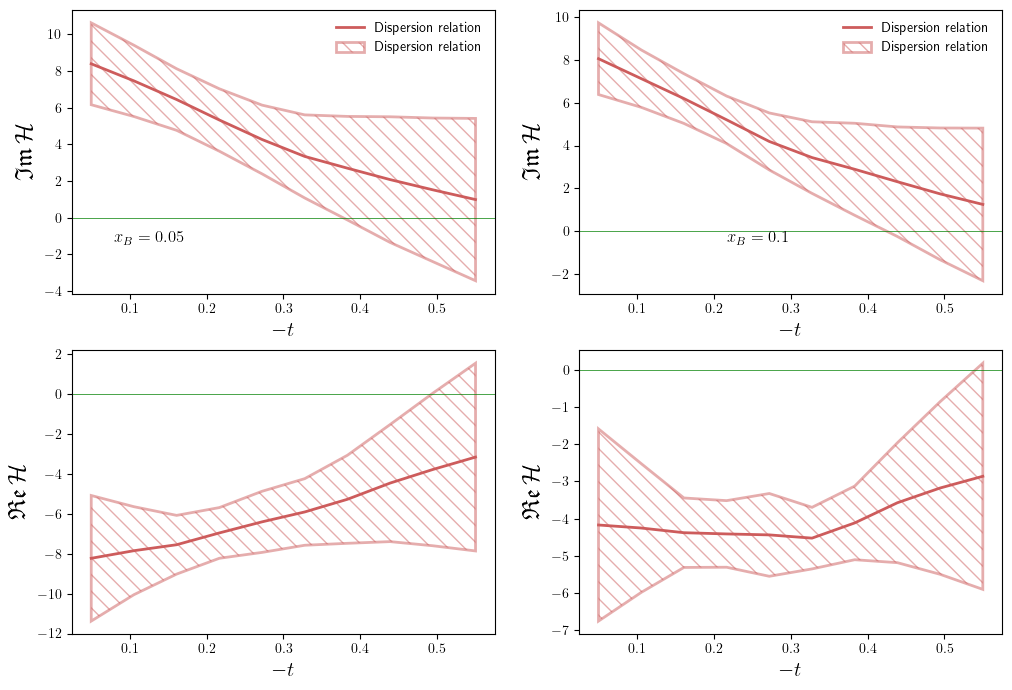

In [38]:
th2.name = "Dispersion relation"
fig = gplot.CFFt(cffs=['ImH', 'ReH'],  lines=th2, bands=[th2])

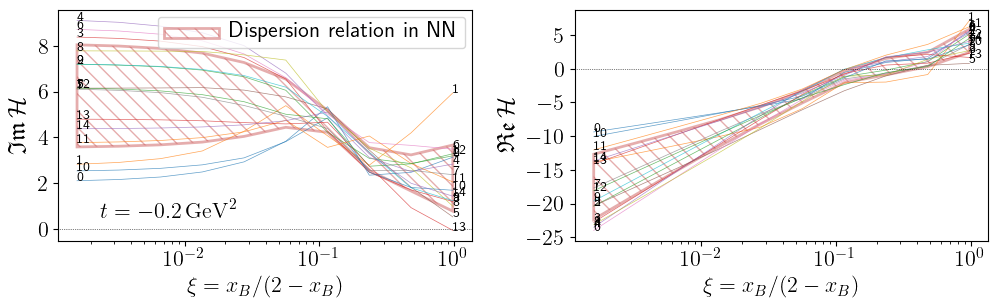

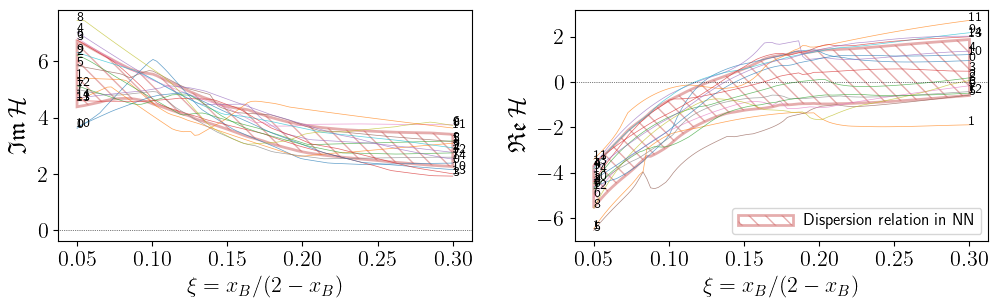

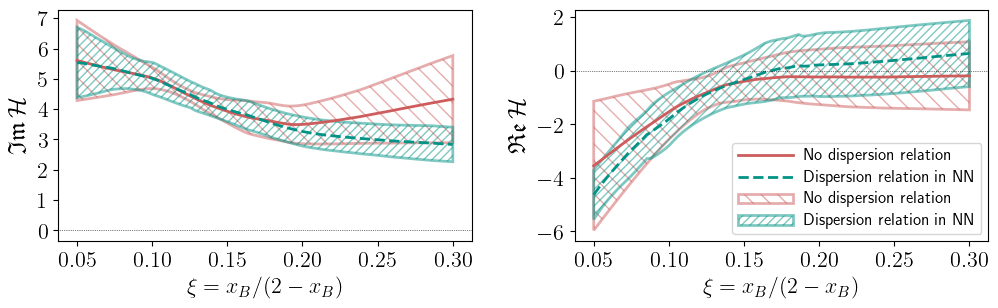

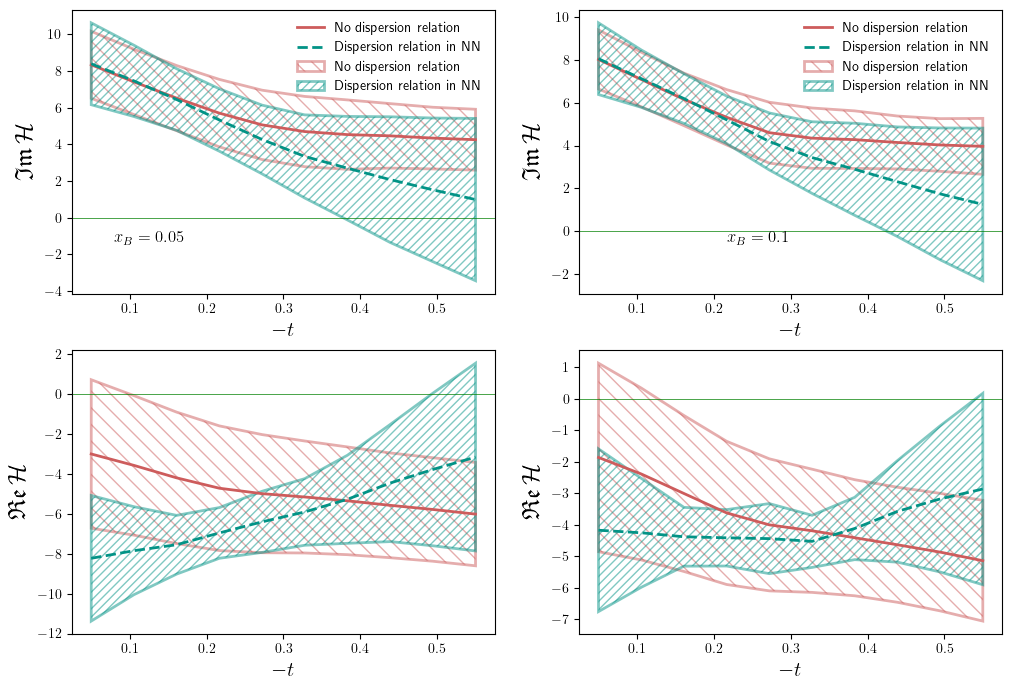

In [39]:
th.name = "No dispersion relation"
th2.name = "Dispersion relation in NN"
fig = gplot.CFF3log(cffs=['ImH', 'ReH'],  mesh=th2, bands=[th2], tval=-0.2)
fig = gplot.CFF3(cffs=['ImH', 'ReH'],  mesh=th2, bands=[th2])
fig = gplot.CFF3(cffs=['ImH', 'ReH'],  lines=[th, th2], bands=[th, th2])
fig = gplot.CFFt(cffs=['ImH', 'ReH'],  lines=[th, th2], bands=[th, th2])

## Test with 4 CFFs

In [139]:
class CustomNetwork_4(nn.Module):
    def __init__(self):
        super(CustomNetwork_4, self).__init__()

        # Define the layers for the network
        self.n1 = nn.Linear(2, 12)  # 2 input features, 7 hidden units
        self.n2 = nn.Linear(12, 19)  # 7 hidden units, 7 hidden units
        self.n3 = nn.Linear(19, 2)  # 7 hidden units, 2 output features
        
        self.n1p = nn.Linear(1, 12)  # 2 input features, 7 hidden units
        self.n2p = nn.Linear(12, 19)  # 7 hidden units, 7 hidden units
        self.n3p = nn.Linear(19, 1)  # 7 hidden units, 2 output features

    def forward(self, x):
        
       
        x0 = x
        
        # Build Im network
        x = torch.relu(self.n1(x0))
        x = torch.relu(self.n2(x))
        output1 = self.n3(x)
        
        # Build D network
        # build the input tensor
        x0_1 = torch.cat((x0[:,1].unsqueeze(1),), dim=0)
       
        x2 = torch.relu(self.n1p(x0_1))
        x2 = torch.relu(self.n2p(x2))
        output2 = self.n3p(x2)
        
        #concatenate outputs
        output = torch.cat((output1, output2), dim=1)
       
        return output 

In [140]:
class NNTest_DR_4(g.model.NeuralModel_DR, g.eff.DipoleEFF, g.dvcs.BMK, g.cff.DispersionCFF):
    
    def build_net(self):
        '''Overriding the default architecture and optimizer'''
        nn_model = CustomNetwork_4()
        optimizer = torch.optim.Rprop(nn_model.parameters(),
                lr=0.05)
        return nn_model, optimizer
    
    def subtraction(self, pt): #This should use the NN, the real part will be calculated by the CFF_Dispersion methods
        """Subtraction constant."""
        #print("I am here in D")
        #refer to the location of D in output layer (defined in the next cell)
        return self.cffs(2, pt, xi)
    
    def ImH(self, pt, xi=0) -> float:
        """Return Im(CFF H) for kinematic point."""
        #refer to the location of Im H in output layer (defined in the next cell)
        return self.cffs(0, pt, xi)
    
    def ImE(self, pt, xi=0):
        """Return Im(CFF E) for kinematic point."""
        return self.cffs(1, pt, xi)
    
    def ImHt(self, pt, xi=0):
        """Return Im(CFF Ht) for kinematic point."""
        return self.zero(pt)
    
    def ImEt(self, pt, xi=0):
        """Return Im(CFF Et) for kinematic point."""
        return self.zero(pt)

In [141]:
th3 = NNTest_DR_4(output_layer=['ImH', 'ImE', 'D'])#'ImH', 'ReH', 'ImE', 'ReE', 'ImHt', 'ReHt', 'ImEt', 'ReEt'])#

In [142]:
#f = g.fitter.NeuralFitter(fitpoints, th3, nnets=10, maxtries=100, nbatch=6, batchlen=10, minprob=0.05)
#f.fitgood()
f = g.fitter.NeuralFitter(fitpoints, th3, nnets=10, batchlen=10, regularization='L2', lx_lambda=0.002)
f.fit()


Epoch  10: train error = 1.6515 test error = 1.4347 -
Epoch  20: train error = 1.3993 test error = 1.2853 -
Epoch  30: train error = 1.3494 test error = 1.3299 +
Epoch  40: train error = 1.3286 test error = 1.3321 +
Epoch  50: train error = 1.3139 test error = 1.3766 +
Epoch  60: train error = 1.3076 test error = 1.3955 +
Epoch  70: train error = 1.2987 test error = 1.4167 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.2853306337603418

Epoch  10: train error = 1.3216 test error = 2.3065 -
Epoch  20: train error = 0.9961 test error = 1.2351 -
Epoch  30: train error = 0.9560 test error = 1.2222 -
Epoch  40: train error = 0.9311 test error = 1.2150 -
Epoch  50: train error = 0.9182 test error = 1.1780 -
Epoch  60: train error = 0.9090 test error = 1.1868 +
Epoch  70: train error = 0.9039 test error = 1.1701 -
Epoch  80: train error = 0.8976 test error = 1.1834 +
Epoch  90: train error = 0.8919 test error = 1.1835 +
Epoch 100: train error = 0.8892 test error = 1.1

In [143]:
with shelve.open("CLAS15-8-NDR") as shelve_file:
    # Store num list in shelf file 
    shelve_file['DR_HE'] = th3.nets
    DRHE = shelve_file['DR_HE']
    print(f"Keys = {list(shelve_file.keys())}")

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x94 in position 3: invalid start byte

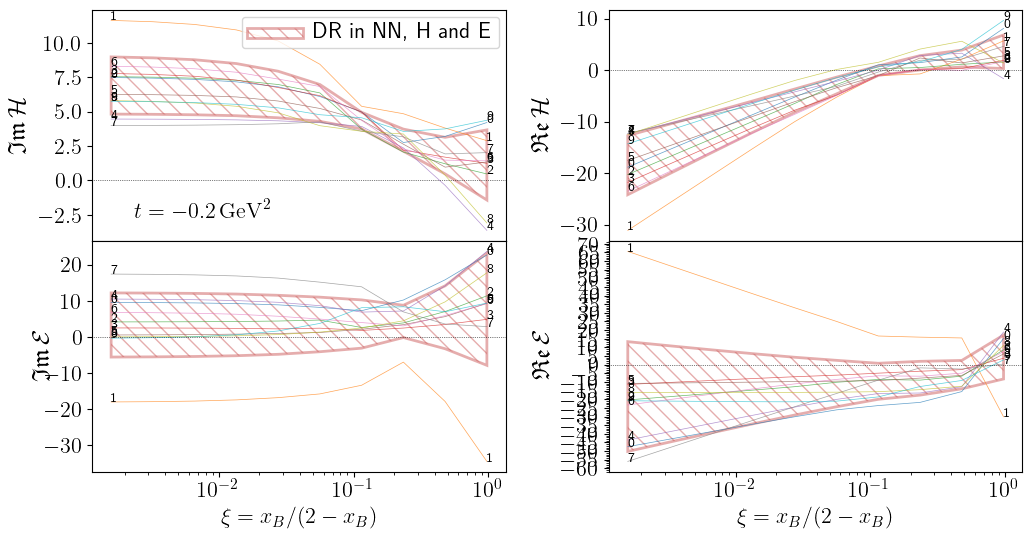

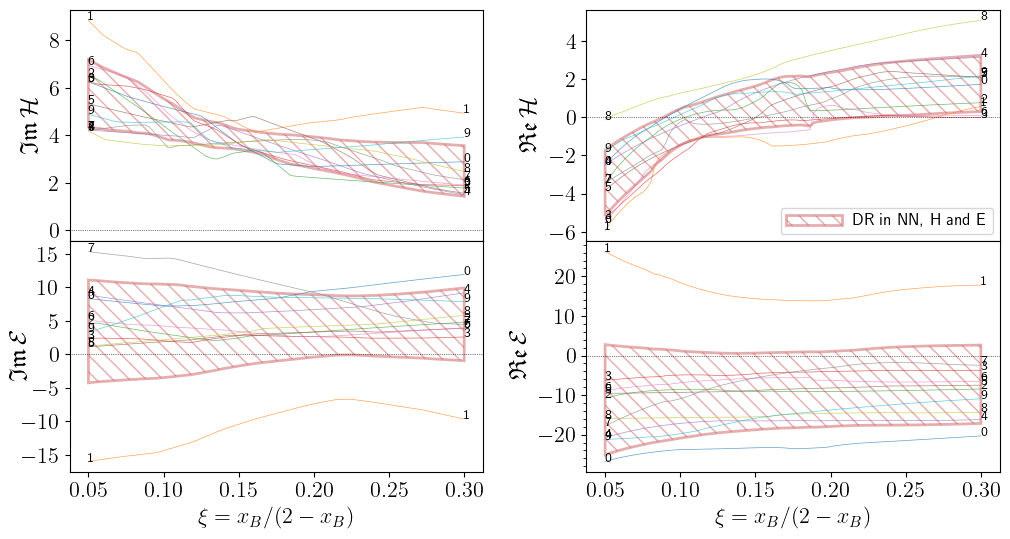

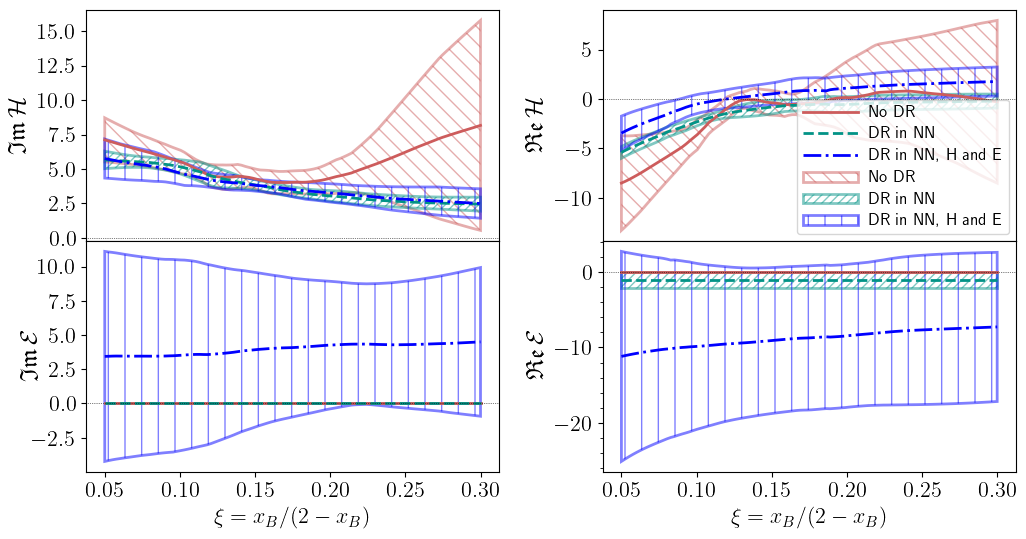

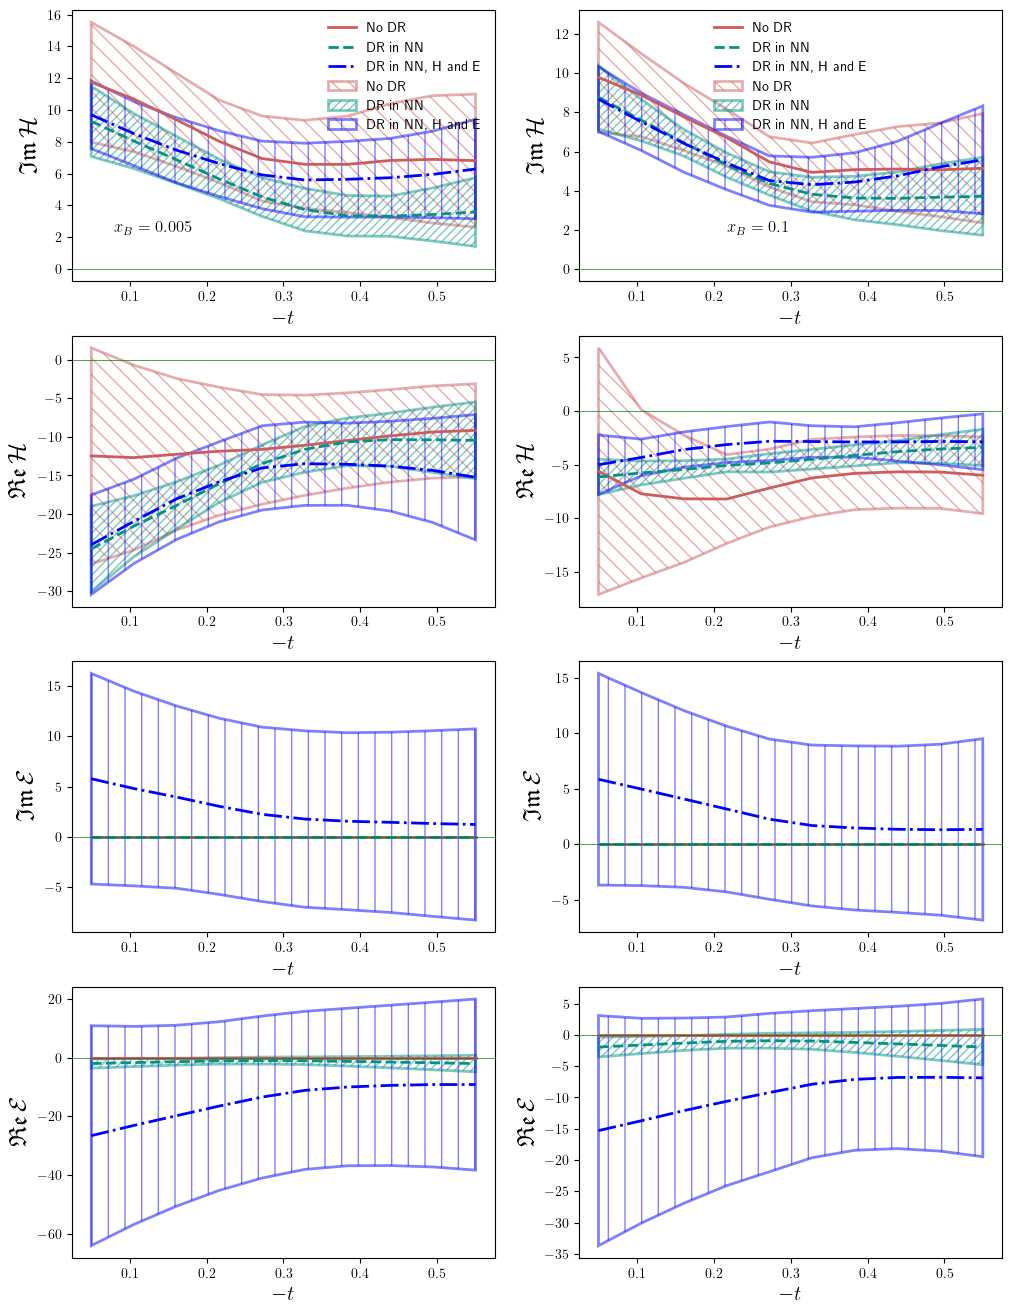

In [97]:
th.name = "No DR"
th2.name = "DR in NN"
th3.name = "DR in NN, H and E"
fig = gplot.CFF3log(cffs=['ImH', 'ReH', 'ImE', 'ReE'],  mesh=th3, bands=[th3], tval=-0.2)
fig = gplot.CFF3(cffs=['ImH', 'ReH', 'ImE', 'ReE'],  mesh=th3, bands=[th3])
fig = gplot.CFF3(cffs=['ImH', 'ReH', 'ImE', 'ReE'],  lines=[th, th2, th3], bands=[th, th2, th3])
fig = gplot.CFFt(cffs=['ImH', 'ReH', 'ImE', 'ReE'],  lines=[th, th2, th3], bands=[th, th2, th3])

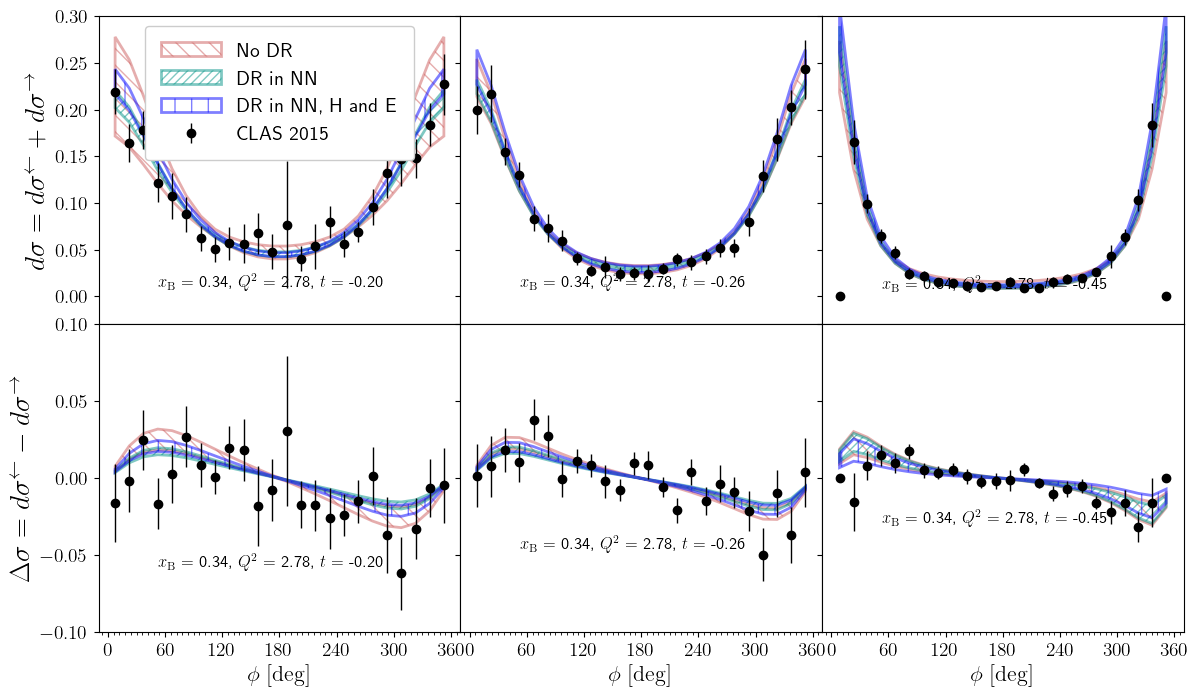

In [98]:
fig = plots.CLAS15phi(bands=[th,th2,th3])

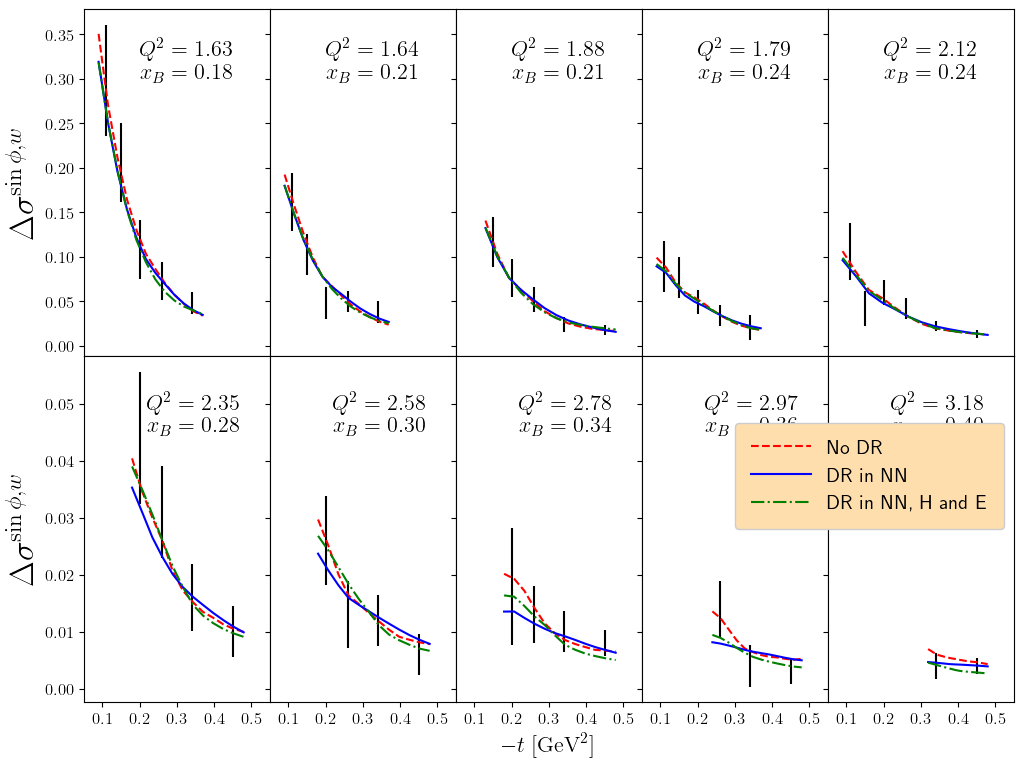

In [99]:
fig = gplot.CLAS15xs(lines=[th,th2,th3])

## D-term using NN

In [100]:
'''D = []
#print(th2.m.__dict__)
#print(getattr(th2, 'nn_model'))
for pt in ptts[::-1]:
    #print(-th2.m.subtraction(pt).detach().numpy()*18./25.)
    Ds = []
    for k in range(len(th2.m.nets)):
        th2.m.parameters['nnet'] = k
        # NOTE: subtraction in code is equal to -\Delta(t) !
        Ds.append(-th2.m.subtraction(pt).detach().numpy()*18./25.) 
        #print(-th2.m.ImH(pt).detach().numpy()*18./25.)
    Ds = np.array(Ds)
    print("{}, {}: {} +- {}".format(pt.xB, pt.t, Ds.mean(), Ds.std()))
    D.append((pt.tm, Ds.mean(), Ds.std())) '''

'D = []\n#print(th2.m.__dict__)\n#print(getattr(th2, \'nn_model\'))\nfor pt in ptts[::-1]:\n    #print(-th2.m.subtraction(pt).detach().numpy()*18./25.)\n    Ds = []\n    for k in range(len(th2.m.nets)):\n        th2.m.parameters[\'nnet\'] = k\n        # NOTE: subtraction in code is equal to -\\Delta(t) !\n        Ds.append(-th2.m.subtraction(pt).detach().numpy()*18./25.) \n        #print(-th2.m.ImH(pt).detach().numpy()*18./25.)\n    Ds = np.array(Ds)\n    print("{}, {}: {} +- {}".format(pt.xB, pt.t, Ds.mean(), Ds.std()))\n    D.append((pt.tm, Ds.mean(), Ds.std())) '

In [101]:
''' D_array = np.array(D[1], dtype=[('tm', float), ('mean', float), ('std', float)])
print(D_array.mean)
print(D_array.std)
scaled_mean = D_array['mean'] * (25./18.)
print(scaled_mean) '''

" D_array = np.array(D[1], dtype=[('tm', float), ('mean', float), ('std', float)])\nprint(D_array.mean)\nprint(D_array.std)\nscaled_mean = D_array['mean'] * (25./18.)\nprint(scaled_mean) "

In [102]:
import random
ptts = []
tm_list = [0.1, 0.2, 0.3, 0.4]

for tm in tm_list:
    rndm_idx = random.randint(0, len(tm_list)-1)
    ptb = g.dset[102][rndm_idx].copy()  # take some random point and set/change -t
    ptb.t = -tm
    ptb.tm = tm
    th15.prepare(ptb)
    ptts.append(ptb)


print(ptts)

[DataPoint: XUUw = 0.574, DataPoint: XUUw = 1.437, DataPoint: XUUw = 0.364, DataPoint: XUUw = 0.574]


In [103]:
th2.name = "DR in NN whit 2 CFFs"
th3.name = "DR in NN with 4 CFFs"

In [104]:
#print(th2.m.__dict__)
#print(getattr(th3, 'nn_model'))

In [ ]:
D = []
for th in [th2, th3]:
    print("\n---- [{} - {}] ----".format(th.name, th.description))
    A = []
    for pt in ptts[::-1]:
        Ds = []
        for k in range(len(th.m.nets)):
            th.m.parameters['nnet'] = k
            # NOTE: subtraction in code is equal to -\Delta(t) !
            Ds.append(-th.m.subtraction(pt).detach().numpy()*18./25.) 
            #print(-th2.m.ImH(pt).detach().numpy()*18./25.)
        Ds = np.array(Ds)
        print("{}, {}: {} +- {}".format(pt.xB, pt.t, Ds.mean(), Ds.std()))
        A.append((pt.tm, Ds.mean(), Ds.std()))
    th.m.parameters['nnet'] = 'ALL'    
    D.append(A)


---- [DR in NN whit 2 CFFs - N/A] ----
0.185, -0.4: -1.5623595714569092 +- 2.384185791015625e-07
0.185, -0.3: -1.2814488410949707 +- 1.1920928955078125e-07
0.185, -0.2: -0.6908986568450928 +- 5.960464477539063e-08
0.185, -0.1: 0.7789248824119568 +- 0.0

---- [DR in NN with 4 CFFs - N/A] ----
0.185, -0.4: 1.4493213891983032 +- 1.1920928955078125e-07
0.185, -0.3: 0.97267085313797 +- 5.960464477539063e-08
0.185, -0.2: 0.5037320852279663 +- 5.960464477539063e-08
0.185, -0.1: 0.3139263987541199 +- 0.0


In [60]:
D = []
for th in [th2, th3]:
    print("\n---- [{} - {}] ----".format(th.name, th.description))
    A = []
    for pt in ptts[::-1]:
        Ds = np.array([-th.m.subtraction(pt).detach().numpy()*18./25. for k in range(len(th.m.nets))])
        print("{}, {}: {} +- {}".format(pt.xB, pt.t, Ds.mean(), Ds.std()))
        A.append((pt.tm, Ds.mean(), Ds.std()))
    th.m.parameters['nnet'] = 'ALL'    
    D.append(A)


---- [DR in NN whit 2 CFFs - N/A] ----
0.185, -0.4: -1.5623595714569092 +- 2.384185791015625e-07
0.185, -0.3: -1.2814488410949707 +- 1.1920928955078125e-07
0.185, -0.2: -0.6908986568450928 +- 5.960464477539063e-08
0.185, -0.1: 0.7789248824119568 +- 0.0

---- [DR in NN with 4 CFFs - N/A] ----
0.185, -0.4: 1.4493213891983032 +- 1.1920928955078125e-07
0.185, -0.3: 0.97267085313797 +- 5.960464477539063e-08
0.185, -0.2: 0.5037320852279663 +- 5.960464477539063e-08
0.185, -0.1: 0.3139263987541199 +- 0.0


In [108]:
np.array(D[0]).mean(axis=0)

array([2.50000000e-01, 1.02728567e+00, 4.29153459e-08])

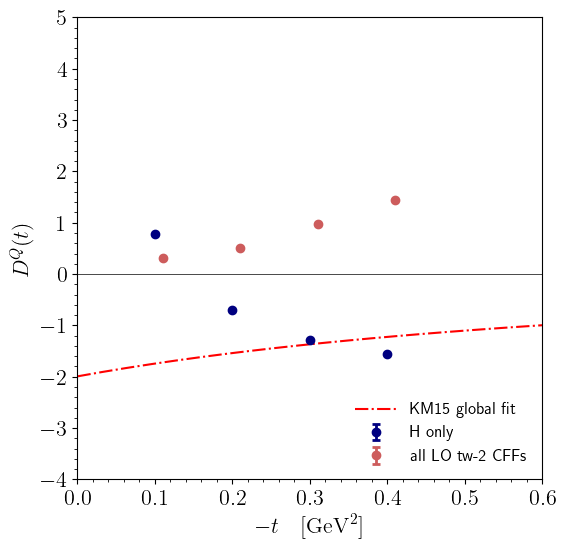

In [61]:
NPTS = 20
ts = np.linspace(0, 0.6, NPTS)
KMS = np.array([-(18./25.)*2.768/(1.+tm/1.204**2)**2 for tm in ts])
CDS = np.array(D[0])
CADS = np.array(D[1])
fig, ax = plt.subplots(1, 1,  figsize=[6,6])
ax.axhline(y=0, linewidth=0.5, color='k')  # y=0 thin line
ax.plot(ts, KMS, 'r-.', label='KM15 global fit')
ax.errorbar(CDS[:,0], CDS[:,1], CDS[:,2], linestyle='None', color='navy',
            elinewidth=2, capsize=3, capthick=2, marker='o', label='H only')
ax.errorbar(CADS[:,0,]+0.01, CADS[:,1], CADS[:,2], linestyle='None', elinewidth=2,
            capsize=3, capthick=2, marker='o', color='indianred', label='all LO tw-2 CFFs')

ax.set_xlim(0.0, 0.6)
ax.set_ylim(-4, 5)
ax.legend(loc=4, handlelength=2.5,
            prop=matplotlib.font_manager.FontProperties(size="large")
        ).draw_frame(0)
ax.set_xlabel(r'$-t \quad [{\rm GeV}^2]$', fontsize=16)
ax.set_ylabel(r'$D^{Q}(t)$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.xaxis.set_major_locator(
        matplotlib.ticker.MultipleLocator(0.1)) 
ax.xaxis.set_minor_locator(
        matplotlib.ticker.MultipleLocator(0.02)) 
ax.yaxis.set_major_locator(
        matplotlib.ticker.MultipleLocator(1.)) 
ax.yaxis.set_minor_locator(
        matplotlib.ticker.MultipleLocator(0.2)) 


In [54]:

print(th2.m.subtraction(ptts[0]).detach().numpy()*18./25.)
print(th3.m.subtraction(ptts[0]).detach().numpy()*18./25.)

print(th2.m.subtraction(ptts[1]).detach().numpy()*18./25.)
print(th3.m.subtraction(ptts[1]).detach().numpy()*18./25.)

print(th2.m.subtraction(ptts[2]).detach().numpy()*18./25.)
print(th3.m.subtraction(ptts[2]).detach().numpy()*18./25.)

print(th2.m.subtraction(ptts[3]).detach().numpy()*18./25.)
print(th3.m.subtraction(ptts[3]).detach().numpy()*18./25.)

[-0.7789249]
[-0.3139264]
[0.6908986]
[-0.503732]
[1.281449]
[-0.9726709]
[1.5623598]
[-1.4493213]


In [59]:

print((th2.m.ImH(g.dset[102][5]).detach().numpy()*18./25.).std())
print((th2.m.ImH(g.dset[102][6]).detach().numpy()*18./25.).std())
print((th2.m.ImH(ptts[1]).detach().numpy()*18./25.).std())

0.0
0.0
0.0


## Pressure Distribution
### Code for pressure in terms of D-term

In [74]:
def Dterm(t, D0=-1.6, M=0.7, p=3):
    """D-term parametrization"""
    return D0/(1-t/M**2)**p

In [ ]:
# Plotting this D-term
fig, ax = plt.subplots(1, 1, figsize=[7,5])
tms = np.linspace(0,2)
ax.plot(tms, Dterm(-tms), 'b-')
ax.set_ylabel(r'D(t)', fontsize=14)
ax.set_xlabel(r'$-t\quad[{\rm GeV}^2]$', fontsize=14)
ax.axhline(linestyle='--', color='g', lw=1)
ax.set_xlim(0,2)
ax.set_ylim(-2,0)
# fig.savefig('figs/dterm.pdf')

In [76]:
def pressureNnaive(r, Dterm, **args):
    """Pressure distribution r^2*p(r) in GeV/fm for given Dterm(t) function"""
    GeVfm = 0.197
    Mp = 0.938
    rGeV = r/GeVfm
    intg = quad(lambda t: np.sin(np.sqrt(-t)*rGeV)*t*Dterm(t, **args), -np.inf, 0, epsabs=0)
    return intg[0]/(24*np.pi**2*Mp*rGeV) * rGeV**2 / GeVfm

In [77]:
def pressureN(r, Dterm, **args):
    """Pressure distribution r^2*p(r) in GeV/fm for given Dterm(t) function"""
    GeVfm = 0.197
    Mp = 0.938
    rGeV = r/GeVfm
    # variable change x=-t^2, so QUADPACK Fourier integral method can be used
    intg = quad(lambda x: 2*x*(-x**2)*Dterm(-x**2, **args), 0, np.inf, weight='sin', wvar=rGeV)
    return intg[0]/(24*np.pi**2*Mp*rGeV) * rGeV**2 / GeVfm

In [78]:
def pressureA(r, D0=-1.6, M=0.7, p=3):
    """Pressure distribution r^2*p(r) in GeV/fm for specific Dterm(t) function
    
     D(t) = D0/(1-t/M^2)^p  with p=2 or 3
    
    """
    GeVfm = 0.197
    Mp = 0.938
    assert p in [2,3]
    rGeV = r/GeVfm
    res = D0 * M**(2+p) * rGeV**(p-3) * np.exp(-M*rGeV) * (M*rGeV - p)
    return rGeV**2 * res / (2**(2*p) * 3 * np.pi * Mp) / GeVfm


In [ ]:
D0val, Mval, pval = -1.6, 0.7, 3
pressureA(0.3, D0=D0val, M=Mval, p=pval), pressureNnaive(0.3, Dterm, D0=D0val, M=Mval, p=pval), pressureN(0.3, Dterm, D0=D0val, M=Mval, p=pval)

In [ ]:
D0val, Mval, pval = -1.6, 1.3, 2
pressureA(0.3, D0=D0val, M=Mval, p=pval), pressureNnaive(0.3, Dterm, D0=D0val, M=Mval, p=pval), pressureN(0.3, Dterm, D0=D0val, M=Mval, p=pval)

In [81]:
pressure = pressureN

## Pressure distribution - mean values

In [ ]:
# Plotting the distribution for ChiQSM parameters from hep-ph/0702030
# d_1(0) = -2.35, M = 0.646,  so D(0) = 1.88
fig, ax = plt.subplots(1, 1, figsize=[7,5])
rs = np.linspace(0.001,2,100)
ps = []
for r in rs:
    ps.append(pressure(r, Dterm, D0=-1.88, M=0.646, p=2))
ax.plot(rs, ps, 'r-', label='ChiQSM')
ax.set_ylabel(r'$r^2 p(r) \quad[{\rm GeV}/{\rm fm}]$', fontsize=14)
ax.set_xlabel(r'$r\quad[{\rm fm}]$', fontsize=14)
ax.axhline(linestyle='--', color='g', lw=1)
ax.set_xlim(0,2)
ax.legend(loc="upper right", fontsize=15)
#fig.savefig('figs/pressure.pdf')

In [ ]:
Mval = np.sqrt(1.06)
D0val = -2.04 * (4./5.) # d_1 is grav. form. fact.
D0valA = -2.04 * (18./25.)  # d_1 is subtr. const
D0valB = -2.04 * (18./25.)*(5./9.)  # wild guess
fig, ax = plt.subplots(1, 1, figsize=[7,7])
rs = np.linspace(0.001,2,100)
ps = []
psA = []
psB = []
for r in rs:
    ps.append(pressure(r, Dterm, D0=D0val, M=Mval, p=2.76))   
    psA.append(pressure(r, Dterm, D0=D0valA, M=Mval, p=2.76))
    psB.append(pressure(r, Dterm, D0=D0valB, M=Mval, p=2.76))
ax.plot(rs, ps, 'b--', label='d1 is grav. FF')
ax.plot(rs, psA, 'r-', label='d1 is subtr. const.')
ax.plot(rs, psB, 'k-.', label='wild guess')
ax.set_ylabel(r'$r^2 p(r) \quad[{\rm GeV}/{\rm fm}]$', fontsize=14)
ax.set_xlabel(r'$r\quad[{\rm fm}]$', fontsize=14)
ax.axhline(linestyle='--', color='g', lw=1)
ax.set_xlim(0,2)
ax.legend(loc="upper right", fontsize=15)
ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.001))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.2))

### Pressure distribution - uncertainties

In [84]:
d0, M, p = -2.04 * (18./25.)*(5./9.), np.sqrt(1.06), 2.76
d0err = np.sqrt(0.14**2 + 0.33**2) * (18./25.)*(5./9.)
M2err = np.sqrt(0.1**2 + 0.15**2)
Merr = M2err/2/M
perr = np.sqrt(0.25**2 + 0.5**2)

In [85]:
# Sampling from Gaussian/normal distribution using scipy's stats routines
ss = 50 #  sample size
d0MC = norm.rvs(d0, d0err, size=ss)
MMC = norm.rvs(M, Merr, size=ss)
pMC = norm.rvs(p, perr, size=ss)

In [86]:
rs = np.linspace(0.01,2,100)
psmean = []
psup = []
psdown = []
for r in rs:
    pressMC = []
    for k in range(ss):
        pressMC.append(pressure(r, Dterm, D0=d0MC[k], M=MMC[k], p=pMC[k]))
    mean, std = 1000*np.mean(pressMC), 1000*np.std(pressMC)
    psmean.append(mean)
    psup.append(mean+std)
    psdown.append(mean-std)

In [ ]:
# I need to use "wild guess" option above to get agreement Fig. from Nature
fig, ax = plt.subplots(1, 1, figsize=[7,7])
ax.plot(rs, psmean, 'k-', label='wild guess')
ax.fill_between(rs, psup, psdown,
                    facecolor='limegreen',
                    edgecolor='black', linewidth=1, zorder=0)
ax.set_ylabel(r'$r^2 p(r) \quad[\times 10^{-3}\; {\rm GeV}/{\rm fm}]$', fontsize=14)
ax.set_xlabel(r'$r\quad[{\rm fm}]$', fontsize=14)
ax.axhline(linestyle='--', color='g', lw=1)
ax.set_xlim(0,2)
ax.set_ylim(-8, 17)
ax.legend(loc="upper right", fontsize=15)
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
#fig.savefig('figs/pressure_nat.pdf')

In [88]:
d0, M, p = -2.04 * (18./25.)*(5./9.), np.sqrt(1.06), 2.76
d0err = 1.4 * (18./25.)  # as seen above, this is essentially t-independent
M2err = np.sqrt(0.1**2 + 0.15**2)
Merr = M2err/2/M
perr = np.sqrt(0.25**2 + 0.5**2)

In [89]:
d0MC = norm.rvs(d0, d0err, size=ss)
MMC = norm.rvs(M, Merr, size=ss)
pMC = norm.rvs(p, perr, size=ss)

In [90]:
rs = np.linspace(0.01,2,100)
psmean = []
psup = []
psdown = []
for r in rs:
    pressMC = []
    for k in range(ss):
        pressMC.append(pressure(r, Dterm, D0=d0MC[k], M=MMC[k], p=pMC[k]))
    mean, std = 1000*np.mean(pressMC), 1000*np.std(pressMC)
    psmean.append(mean)
    psup.append(mean+std)
    psdown.append(mean-std)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=[7,7])
ax.plot(rs, psmean, 'k-', label='wild guess')
ax.fill_between(rs, psup, psdown,
                    facecolor='mediumslateblue',
                    edgecolor='black', linewidth=1, zorder=0)
ax.set_ylabel(r'$r^2 p(r) \quad[\times 10^{-3}\; {\rm GeV}/{\rm fm}]$', fontsize=14)
ax.set_xlabel(r'$r\quad[{\rm fm}]$', fontsize=14)
ax.axhline(linestyle='--', color='g', lw=1)
ax.set_xlim(0,2)
ax.set_ylim(-8, 17)
ax.legend(loc="upper right", fontsize=15)
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
#fig.savefig('figs/pressure_NNet.pdf')

## Local fit of ImH and ReH to CLAS data

In [ ]:
tNN = th2
tNN.m.output_layer 

In [93]:
binD = {}
binS = {}
binDS = {}

In [94]:
def tmin(xB, Q2):
    """BMK Eq. (31)"""

    eps2 = (4. * xB**2 * Mp2) / Q2
    return (-Q2 * ( 2. * (1.-xB)*(1. - np.sqrt(1.+eps2)) + eps2 ) / (
            4. * xB * (1.-xB) + eps2 ))

In [95]:
def makefit(tbin, nxis): 
    """ Perform simultaneous fit of both ImH and ReH."""
    for xbin in range(nxis):
        binD[(tbin,xbin)] = BSD.loc[(tmlims[tbin] < BSD.tm) & 
                                    (BSD.tm < tmlims[tbin+1]) & 
                             (xilims[xbin] < BSD.xi) & (BSD.xi < xilims[xbin+1])]
        binS[(tbin,xbin)] = BSS.loc[(tmlims[tbin] < BSS.tm) & 
                                    (BSS.tm < tmlims[tbin+1]) & 
                             (xilims[xbin] < BSS.xi) & (BSS.xi < xilims[xbin+1])]
        binDS[(tbin,xbin)] = pd.concat([binD[(tbin,xbin)], 
                                        binS[(tbin,xbin)]], ignore_index=True)
    totchi = 0
    ndof = 0
    sys.stdout.write('-- Bin: ')
    CFFs = ['pImH', 'pReH']
    CFFvals = []
    CFFerrs = []
    xis = []
    pts = []
    for xbin in range(nxis):
        # Model creation
        #m = model.ModelLocal()
        #m.parameters['pImH'] = 10.
        #th = Approach.BM10tw2(m)
        th.name = 'local-bin-%2s' % (xbin,)
        th.model.fix_parameters('ALL')
        th.model.release_parameters(*CFFs)
        # Fit to data in given bin
        sys.stdout.write('%2s .. ' % (xbin,))
        f = fitter.FitterMinuit(binDS[(tbin,xbin)].pt.values, th)
        xis.append(binDS[(tbin,xbin)].xi.mean())
        pts.append(binD[(tbin,xbin)].pt.values[0])
        #f.printMode = 2
        f.fit()
        totchi += th.chisq(f.fitpoints)[0]
        ndof += len(f.fitpoints)-len(CFFs)
        vals= []
        errs = []
        for p in CFFs:
                vals.append(th.m.parameters[p])
                errs.append(np.sqrt(th.m.covariance[p,p]))
        CFFvals.append(vals)
        CFFerrs.append(errs)

    CFFvals = np.array(CFFvals)
    CFFerrs = np.array(CFFerrs)

    print("\n chisq/ndof = {:.1f}/{}".format(totchi,ndof))
    return xis, pts, CFFvals, CFFerrs


In [96]:
def makefitstep(tbin, nxis):
    """ Perform step-wise fit, first ImH, then ReH ... not significant"""
    for xbin in range(nxis):
        binD[(tbin,xbin)] = BSD.loc[(tmlims[tbin] < BSD.tm) & 
                                    (BSD.tm < tmlims[tbin+1]) & 
                             (xilims[xbin] < BSD.xi) & (BSD.xi < xilims[xbin+1])]
        binS[(tbin,xbin)] = BSS.loc[(tmlims[tbin] < BSS.tm) & 
                                    (BSS.tm < tmlims[tbin+1]) & 
                             (xilims[xbin] < BSS.xi) & (BSS.xi < xilims[xbin+1])]
        binDS[(tbin,xbin)] = pd.concat([binD[(tbin,xbin)], 
                                        binS[(tbin,xbin)]], ignore_index=True)
    totchi = 0
    ndof = 0
    sys.stdout.write('-- Bin: ')
    CFFs = ['pImH', 'pReH']
    CFFvals = []
    CFFerrs = []
    xis = []
    pts = []
    for xbin in range(nxis):
        # Model creation
        #m = model.ModelLocal()
        #m.parameters['pImH'] = 10.
        #th = Approach.BM10tw2(m)
        #th.name = 'local-bin-%2s' % (xbin,)
        th.model.fix_parameters('ALL')
        sys.stdout.write('%2s .. ' % (xbin,))
        xis.append(binDS[(tbin,xbin)].xi.mean())
        pts.append(binD[(tbin,xbin)].pt.values[0])
        # Fit to BSD data in given bin
        th.model.release_parameters('pImH')
        f = fitter.FitterMinuit(binD[(tbin,xbin)].pt.values, th)
        #f.printMode = 2   
        f.fit()
        totchi += th.chisq(f.fitpoints)[0]
        ndof += len(f.fitpoints)-1
        valImH = th.m.parameters['pImH']
        errImH = np.sqrt(th.m.covariance['pImH','pImH'])
        # Now fit to BSS data
        th.model.fix_parameters('pImH')
        th.model.release_parameters('pReH')
        f = fitter.FitterMinuit(binS[(tbin,xbin)].pt.values, th)
        f.fit()
        totchi += th.chisq(f.fitpoints)[0]
        ndof += len(f.fitpoints)-1
        th.model.release_parameters('pImH')
        valReH = th.m.parameters['pReH']
        errReH = np.sqrt(th.m.covariance['pReH','pReH'])
        vals= [valImH, valReH]
        errs = [errImH, errReH]
        CFFvals.append(vals)
        CFFerrs.append(errs)

    CFFvals = np.array(CFFvals)
    CFFerrs = np.array(CFFerrs)

    print("\n chisq/ndof = {:.1f}/{}".format(totchi,ndof))
    return xis, pts, CFFvals, CFFerrs

In [97]:
def makefig():
    """Plot the results of the local fits together with NNet and KM fits"""
    xirange = np.linspace(0.05, 0.3, 20)
    CFFs = ['ImH', 'ReH']
    ex_pt = copy.deepcopy(pts[0])
    fig, axs = plt.subplots(1, 2, figsize=[12,6])
    for p in range(2):
        axs[p].errorbar(xis, CFFvals[:,p], CFFerrs[:,p], linestyle='None', marker='s', 
                       label='local fit')
        ys = []
        ys2 = []
        ysNN = []
        ysNNerr = []
        for xi in xirange:
            pt = ex_pt.copy()
            pt.xB = 2*xi/(1+xi)
            del pt.W
            del pt.xi
            del pt.tm
            #utils.fill_kinematics(pt)
            th15.m.g.newcall = 1
            y = getattr(th15.m, CFFs[p])(pt)
            th12.m.g.newcall = 1
            y2 = getattr(th12.m, CFFs[p])(pt)
            try:
                yall = getattr(tNN.m, CFFs[p])(pt)
                ysNN.append(yall.mean())
                ysNNerr.append(yall.std())
            except:
                print('some NN failure')
                pass    
            ys.append(y)
            ys2.append(y2)
        ysNN = np.array(ysNN)
        ysNNerr = np.array(ysNNerr)
        axs[p].fill_between(xirange, ysNN-ysNNerr, ysNN+ysNNerr, alpha=0.2,
                    label=tNN.name, color='green')#, zorder=0)
        axs[p].plot(xirange, ys, 'r-', label='KM15')
        axs[p].plot(xirange, ys2, 'k--', label='KMM12')
        axs[p].set_xlabel(r'$\xi$', fontsize=14)
        axs[p].set_xlim(0.03, 0.31)
    #axs[0].set_ylabel(r'Im(H)', fontsize=14)
    axs[0].set_ylabel(r'$\mathfrak{Im}\,\mathcal{H}$', fontsize=18)
    axs[0].set_ylim(0., 10.)
    axs[1].legend(loc="lower right", fontsize=15)
    axs[1].set_ylabel(r'Re(H)', fontsize=14)
    axs[1].set_ylabel(r'$\mathfrak{Re}\,\mathcal{H}$', fontsize=18)      
    axs[1].axhline(y=0, linewidth=0.8, linestyle=':', color='k')  # y=0 thin line
    axs[1].set_ylim(-10., 4.)
    axs[0].text(0.05, 1, r'$t = {}\,{{\rm GeV}}^2$'.format(pts[0].t), fontsize=15,
                bbox=dict(facecolor='gold', alpha=0.3))
    return fig


In [98]:
#xis, pts, CFFvals, CFFerrs = makefit(0,3)

In [ ]:
fig = makefig()